# House Price Prediction using Regression

In [1]:
# --- Step 1: Library Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Step 2: Load Data from Kaggle's Input Directory ---
# The data is located in a specific path on Kaggle notebooks
DATA_PATH = '../input/house-prices-advanced-regression-techniques/'

train_df = pd.read_csv(DATA_PATH + 'train.csv')
test_df = pd.read_csv(DATA_PATH + 'test.csv')

# Preserve the test IDs for the final submission file
test_ids = test_df['Id']

# Set the 'Id' column as the index
train_df.set_index('Id', inplace=True)
test_df.set_index('Id', inplace=True)

print("Data loaded successfully.")
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

Data loaded successfully.
Train dataset shape: (1460, 80)
Test dataset shape: (1459, 79)


In [2]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


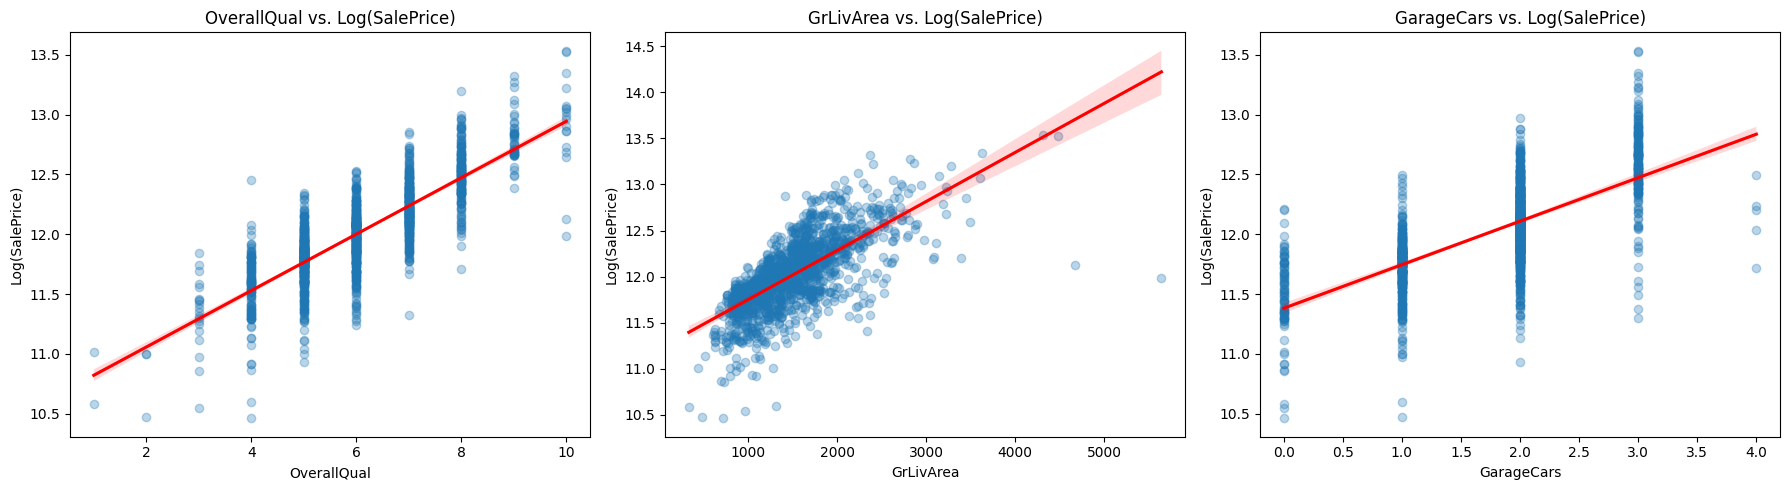

In [3]:
# --- Step 3: Target Variable Analysis ---
# Apply log transformation to correct the positive skewness
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# --- Step 4: Deeper EDA on Top Correlated Features ---
# Visualize relationships for the top 3 numerical features
top_features = ['OverallQual', 'GrLivArea', 'GarageCars']

plt.figure(figsize=(18, 5))
for i, feature in enumerate(top_features):
    plt.subplot(1, 3, i + 1)
    sns.regplot(x=train_df[feature], y=train_df['SalePrice'],
                scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
    plt.title(f'{feature} vs. Log(SalePrice)')
    plt.xlabel(feature)
    plt.ylabel('Log(SalePrice)')

plt.tight_layout()
plt.show()

**Observation:** The plots confirm strong positive linear relationships for Overall Quality, Living Area, and Garage Capacity, validating their importance for our model.

## 3. Preprocessing & Advanced Feature Engineering


In [4]:
# --- Step 5: Combine Data, Preprocess, and Engineer Features ---
# Combine train and test sets for consistent processing
all_data = pd.concat((train_df.loc[:,:'SaleCondition'],
                      test_df.loc[:, :'SaleCondition']))

# Log-Transform skewed numerical input features
numerical_features = all_data.select_dtypes(include=np.number).columns
skewness = all_data[numerical_features].apply(lambda x: skew(x.dropna()))
highly_skewed = skewness[abs(skewness) > 0.75].index
for feature in highly_skewed:
    all_data[feature] = np.log1p(all_data[feature])

# Handle Missing Values (Grouped by strategy)
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
for col in ['Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']:
    all_data[col] = all_data[col].fillna('None')
for col in ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath']:
    all_data[col] = all_data[col].fillna(0)
for col in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities', 'Functional', 'MSZoning']:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)

# Feature Engineering to create more powerful predictors
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) + all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
all_data['Age'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['TotalPorchSF'] = (all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch'])
all_data['HasPool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['HasFireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
all_data['YearsSinceRemod'] = all_data['YrSold'] - all_data['YearRemodAdd']

# One-Hot Encode all remaining 'object' type columns
all_data = pd.get_dummies(all_data, drop_first=True)

print(f"Preprocessing complete. Final data shape: {all_data.shape}")

Preprocessing complete. Final data shape: (2919, 266)


## 4. Model Building with Hyperparameter Tuning

In [5]:
# --- Step 6: Split Data for Final Training ---
X = all_data[:len(train_df)]
y = train_df['SalePrice']
X_test_final = all_data[len(train_df):]

# --- Step 7: Hyperparameter Tuning with GridSearchCV ---
print("Starting hyperparameter tuning...")

# Initialize the base XGBoost model
xgbr = xgb.XGBRegressor(objective='reg:squarederror',
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42,
                        n_jobs=-1) # Use all available CPU cores

# Define a focused grid of parameters that often yield the best results
param_grid = {
    'n_estimators': [1000],          # A higher number of trees is generally better
    'learning_rate': [0.01, 0.05],   # Lower learning rates are more robust
    'max_depth': [3, 4],             # Controls tree complexity to avoid overfitting
    'reg_lambda': [0.1, 1.0]         # L2 regularization for robustness
}

# Set up GridSearchCV to automate the search and find the best model
grid_search = GridSearchCV(estimator=xgbr,
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',
                           cv=5, # Use 5-fold cross-validation for a more stable evaluation
                           verbose=1)

# Run the search on the full training dataset
grid_search.fit(X, y)

# --- Step 8: Analyze Tuning Results ---
print("\n--- Tuning Complete ---")
print(f"Best Parameters Found: {grid_search.best_params_}")
print(f"Best Cross-Validated RMSE: {-grid_search.best_score_:.4f}")

Starting hyperparameter tuning...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

--- Tuning Complete ---
Best Parameters Found: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000, 'reg_lambda': 1.0}
Best Cross-Validated RMSE: 0.1237


## 5. Create Final Submission

In [6]:
# --- Step 9: Create Submission File with the Tuned Model ---
# GridSearchCV automatically refits the best model on the entire training data
best_xgbr = grid_search.best_estimator_
final_predictions_log = best_xgbr.predict(X_test_final)

# Reverse the log transformation to get prices back to their original scale
final_predictions = np.expm1(final_predictions_log)

# Create the submission DataFrame in the required format
submission = pd.DataFrame({'Id': test_ids, 'SalePrice': final_predictions})

# Save the file to the output directory
submission.to_csv('submission.csv', index=False)

print("\nSubmission file 'submission.csv' created successfully! 🚀")
submission.head()


Submission file 'submission.csv' created successfully! 🚀


,Id,SalePrice
0,1461,120984.773438
1,1462,159621.656250
2,1463,196080.562500
3,1464,196831.859375
4,1465,184323.937500
